In [2]:
import os
os.chdir("../")

In [1]:
import pandas as pd

In [3]:
base_rsna_path = "data/rsna-bone-age/validation"

In [12]:
test_df = pd.read_csv(os.path.join(base_rsna_path, "Validation Dataset.csv")).rename(columns={"Image ID": "id", "Bone Age (months)": "boneage"})

In [15]:
test_df['gender'] = test_df['male'].map(lambda x: 0 if x else 1)

In [27]:
# create path column but map it only if the path exists
test_df["path"] = test_df["id"].map(lambda x: os.path.join(base_rsna_path, "boneage-validation-dataset-1", f"{x}.png") if os.path.exists(os.path.join(base_rsna_path, "boneage-validation-dataset-1", f"{x}.png")) else os.path.join(base_rsna_path, "boneage-validation-dataset-2", f"{x}.png"))


In [28]:
test_df['exists'] = test_df['path'].map(os.path.exists)

In [37]:
test_df.drop(columns=['male', 'exists'], inplace=True)

In [38]:
test_df.columns

Index(['id', 'boneage', 'gender', 'path'], dtype='object')

In [39]:
len(test_df)

1425

### Evaluating the results

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

In [129]:
test_results = pd.read_csv("output/inception_gender_validation.csv")

In [130]:
def generate_bins(df):
    num_bins = 10

    # Calculate the bin width
    bin_width = (df['actual_ages'].max() - df['actual_ages'].min()) / num_bins

    # Create the bin boundaries
    bin_boundaries = [df['actual_ages'].min() + i * bin_width for i in range(num_bins + 1)]

    # Create the labels for the bins
    bin_labels = [f'Bin {i+1}' for i in range(num_bins)]

    # Add a new column to the dataframe representing the bin labels
    df['bin'] = pd.cut(df['actual_ages'], bins=bin_boundaries, labels=bin_labels, include_lowest=True)

    # Create a dictionary to store the separate dataframes
    dfs = {}

    # Split the dataframe into separate dataframes based on the bin labels
    for label in bin_labels:
        dfs[label] = df[df['bin'] == label].copy()

    for label, df_bin in dfs.items():
        df_bin.drop('bin', axis=1, inplace=True)

    return dfs

In [131]:
def plot_mae(dfs):
    mae_values = {}

    # Create a dictionary to store the bin ranges and counts
    bin_ranges = {}
    bin_counts = {}

    # Calculate the MAE for each bin and store the bin ranges and counts
    for label, df_bin in dfs.items():
        actual_ages = df_bin['actual_ages']
        predicted_ages = df_bin['predicted_ages']
        mae = (actual_ages - predicted_ages).abs().mean()
        mae_values[label] = mae
        bin_ranges[label] = f'{df_bin["actual_ages"].min()}-{df_bin["actual_ages"].max()}'
        bin_counts[label] = len(df_bin)

    # Convert the MAE values, bin ranges, and counts to pandas Series
    mae_series = pd.Series(mae_values)
    bin_ranges_series = pd.Series(bin_ranges)
    bin_counts_series = pd.Series(bin_counts)

    # Plot the MAE values
    plt.figure(figsize=(10, 6))
    ax = mae_series.plot(kind='bar')
    plt.xlabel('Bins')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE for Each Bin')
    plt.xticks(range(len(bin_ranges)), [f'{bin_ranges_series[i]}\nCount: {bin_counts_series[i]}' for i in range(len(bin_ranges))], rotation=45)
    plt.show()

C:\Users\Beheerder\AppData\Local\Temp\ipykernel_20160\992860037.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin'] = pd.cut(df['actual_ages'], bins=bin_boundaries, labels=bin_labels, include_lowest=True)


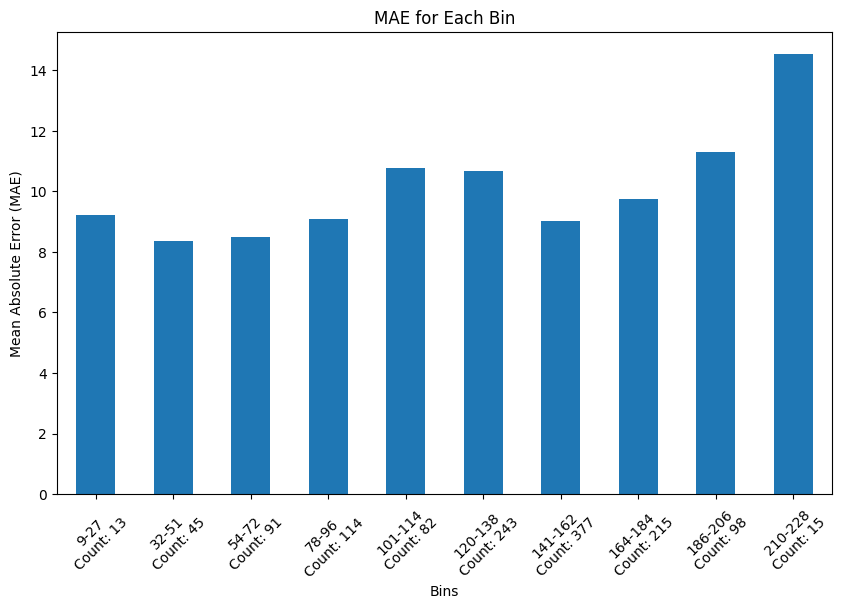

In [133]:
dfs = generate_bins(test_results[test_results['genders']==0])
plot_mae(dfs)

C:\Users\Beheerder\AppData\Local\Temp\ipykernel_20160\992860037.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin'] = pd.cut(df['actual_ages'], bins=bin_boundaries, labels=bin_labels, include_lowest=True)


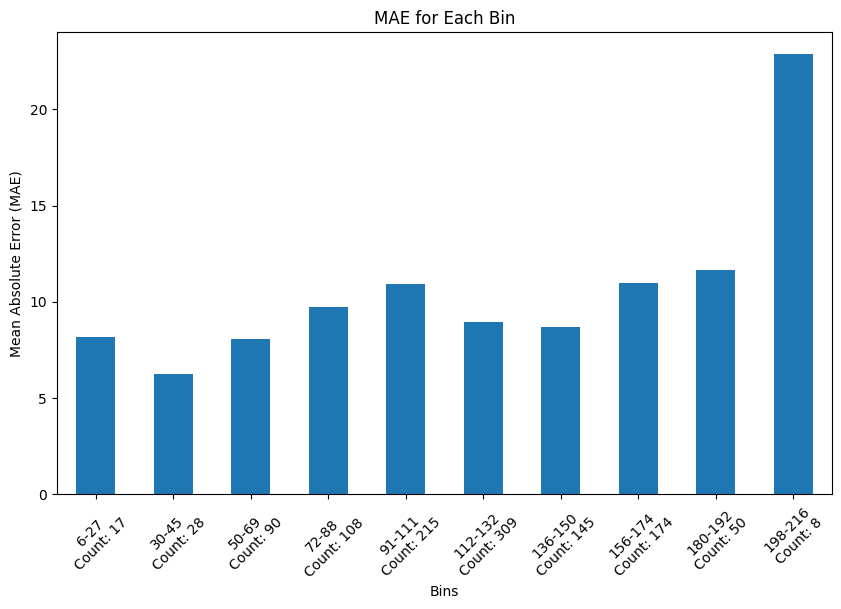

In [134]:
dfs = generate_bins(test_results[test_results['genders']==1])
plot_mae(dfs)